<a href="https://colab.research.google.com/github/ChiriKamau/limaAI/blob/main/notebooks/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#start


In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 787.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.7 MB/s eta 0:00:00


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [ ]:

output_dir = '/content/drive/MyDrive/Tomato_dataset/cnn_crops'

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    zoom_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
datasets_dict = {
    'ripe': {
        'train': train_datagen.flow_from_directory(
            os.path.join(output_dir, 'ripe/train'),
            target_size=(224,224),
            batch_size=16,
            class_mode='categorical'
        ),
        'val': val_datagen.flow_from_directory(
            os.path.join(output_dir, 'ripe/val'),
            target_size=(224,224),
            batch_size=16,
            class_mode='categorical'
        )
    },
    'green': {
        'train': train_datagen.flow_from_directory(
            os.path.join(output_dir, 'green/train'),
            target_size=(224,224),
            batch_size=16,
            class_mode='categorical'
        ),
        'val': val_datagen.flow_from_directory(
            os.path.join(output_dir, 'green/val'),
            target_size=(224,224),
            batch_size=16,
            class_mode='categorical'
        )
    }
}

# Check number of images per class
for color in datasets_dict:
    for split in datasets_dict[color]:
        dataset = datasets_dict[color][split]
        print(f"{color} - {split}: {dataset.samples} images across {dataset.num_classes} classes")


Found 1579 images belonging to 3 classes.
Found 384 images belonging to 3 classes.
Found 4344 images belonging to 4 classes.
Found 946 images belonging to 4 classes.
ripe - train: 1579 images across 3 classes
ripe - val: 384 images across 3 classes
green - train: 4344 images across 4 classes
green - val: 946 images across 4 classes


In [ ]:
# -----------------------------
# Check number of images per class
# -----------------------------
for color in datasets_dict:
    for split in datasets_dict[color]:
        dataset = datasets_dict[color][split]
        print(f"\n{color} - {split}:")
        for class_name, count in zip(dataset.class_indices.keys(), dataset.classes):
            # Count images per class
            class_count = sum(dataset.classes == dataset.class_indices[class_name])
            print(f"  {class_name}: {class_count} images")



ripe - train:
  R_ber: 447 images
  R_healthy: 768 images
  R_spots: 364 images

ripe - val:
  R_ber: 80 images
  R_healthy: 194 images
  R_spots: 110 images

green - train:
  G_ber: 475 images
  G_healthy: 2141 images
  G_lateblight: 191 images
  G_spots: 1537 images

green - val:
  G_ber: 41 images
  G_healthy: 481 images
  G_lateblight: 41 images
  G_spots: 383 images


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Function to compute class weights for a generator
def get_class_weights(generator):
    y_train = generator.classes
    classes = np.unique(y_train)
    weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    return dict(zip(classes, weights))

# Compute class weights
ripe_class_weights = get_class_weights(datasets_dict['ripe']['train'])
green_class_weights = get_class_weights(datasets_dict['green']['train'])

print("Ripe class weights:", ripe_class_weights)
print("Green class weights:", green_class_weights)

Ripe class weights: {np.int32(0): np.float64(1.1774794929157346), np.int32(1): np.float64(0.6853298611111112), np.int32(2): np.float64(1.445970695970696)}
Green class weights: {np.int32(0): np.float64(2.2863157894736843), np.int32(1): np.float64(0.507239607659972), np.int32(2): np.float64(5.68586387434555), np.int32(3): np.float64(0.7065712426805465)}


In [ ]:
def create_cnn(num_classes):
    """
    Creates a simple CNN model for image classification.

    Args:
        num_classes: The number of output classes.

    Returns:
        A Keras Sequential model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:

# Light augmentation for memory efficiency
ripe_train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    zoom_range=0.2
).flow_from_directory(
    '/content/drive/MyDrive/Tomato_dataset/cnn_crops/ripe/train',
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

ripe_val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/drive/MyDrive/Tomato_dataset/cnn_crops/ripe/val',
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

# Create model
num_classes = len(ripe_train_gen.class_indices)
ripe_model = create_cnn(num_classes)

# Train with class weights
ripe_save_path = '/content/drive/MyDrive/Tomato_dataset/models/ripe_cnn(v2).h5'
history_ripe = ripe_model.fit(
    ripe_train_gen,
    validation_data=ripe_val_gen,
    epochs=20,
    class_weight=ripe_class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

ripe_model.save(ripe_save_path)
print(f"Ripe CNN trained and saved to {ripe_save_path}")

ripe_model.save('/content/drive/MyDrive/Tomato_dataset/models/ripe_cnn(v2).keras')



Found 1579 images belonging to 3 classes.
Found 384 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 543s 5s/step - accuracy: 0.4443 - loss: 1.2823 - val_accuracy: 0.2760 - val_loss: 1.1938
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 71s 721ms/step - accuracy: 0.4703 - loss: 1.0050 - val_accuracy: 0.4948 - val_loss: 0.9824
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 72s 729ms/step - accuracy: 0.5132 - loss: 0.9969 - val_accuracy: 0.5625 - val_loss: 0.9645
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 72s 726ms/step - accuracy: 0.5585 - loss: 0.9344 - val_accuracy: 0.4479 - val_loss: 1.0137
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 72s 723ms/step - accuracy: 0.5428 - loss: 0.9053 - val_accuracy: 0.5677 - val_loss: 0.9366
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 72s 726ms/step - accuracy: 0.5392 - loss: 0.8716 - val_accuracy: 0.5521 - val_loss: 0.9678
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 72s 724ms/step - accuracy: 0.5785 - loss: 0.8647 - val_accuracy: 0.5599 - val_loss: 0.9393
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 72s 723ms/step - accuracy: 0.5752 - loss: 0.8572 - val_accura

Ripe CNN trained and saved to /content/drive/MyDrive/Tomato_dataset/models/ripe_cnn(v2).h5


In [ ]:
# Light augmentation for memory efficiency
green_train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    zoom_range=0.2
).flow_from_directory(
    '/content/drive/MyDrive/Tomato_dataset/cnn_crops/green/train',
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

green_val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/drive/MyDrive/Tomato_dataset/cnn_crops/green/val',
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

# Create model
num_classes = len(green_train_gen.class_indices)
green_model = create_cnn(num_classes)

# Train with class weights
green_save_path = '/content/drive/MyDrive/Tomato_dataset/models/green_cnn(v2).h5'
history_green = green_model.fit(
    green_train_gen,
    validation_data=green_val_gen,
    epochs=20,
    class_weight=green_class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

green_model.save(green_save_path)
print(f"Green CNN trained and saved to {green_save_path}")

green_model.save('/content/drive/MyDrive/Tomato_dataset/models/green_cnn(v2).keras')

Found 4344 images belonging to 4 classes.
Found 946 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 862s 3s/step - accuracy: 0.2617 - loss: 1.5373 - val_accuracy: 0.0465 - val_loss: 1.3691
Epoch 2/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 201s 738ms/step - accuracy: 0.1480 - loss: 1.3155 - val_accuracy: 0.1332 - val_loss: 1.3695
Epoch 3/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 201s 738ms/step - accuracy: 0.1920 - loss: 1.2657 - val_accuracy: 0.0930 - val_loss: 1.3415
Epoch 4/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 201s 739ms/step - accuracy: 0.2834 - loss: 1.2143 - val_accuracy: 0.1015 - val_loss: 1.3371
Epoch 5/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 202s 741ms/step - accuracy: 0.3033 - loss: 1.2198 - val_accuracy: 0.3922 - val_loss: 1.3779
Epoch 6/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 201s 739ms/step - accuracy: 0.4877 - loss: 1.1875 - val_accuracy: 0.4926 - val_loss: 1.1752
Epoch 7/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 201s 739ms/step - accuracy: 0.5069 - loss: 1.0799 - val_accuracy: 0.4345 - val_loss: 1.2260
Epoch 8/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 201s 738ms/step - accuracy: 0.5072 - lo

Green CNN trained and saved to /content/drive/MyDrive/Tomato_dataset/models/green_cnn(v2).h5


In [ ]:
green_model.save('/content/drive/MyDrive/Tomato_dataset/models/green_cnn.keras')



🔹 Loading model from: /content/drive/MyDrive/Tomato_dataset/models/green_cnn(v2).h5
Found 946 images belonging to 4 classes.
🔹 Evaluating 946 images...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step

🧩 Detected 4 true classes, 4 predicted classes.

✅ Accuracy: 0.5254
✅ F1-score: 0.4903

📊 Classification Report:
              precision    recall  f1-score   support

       G_ber       0.40      0.20      0.26        41
   G_healthy       0.58      0.79      0.67       481
G_lateblight       0.25      0.61      0.35        41
     G_spots       0.50      0.22      0.31       383

    accuracy                           0.53       946
   macro avg       0.43      0.45      0.40       946
weighted avg       0.53      0.53      0.49       946



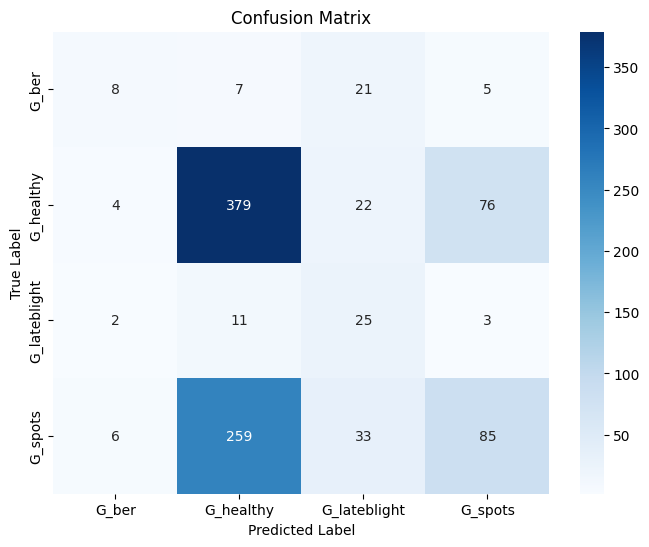


🔹 Loading model from: /content/drive/MyDrive/Tomato_dataset/models/ripe_cnn(v2).keras
Found 384 images belonging to 3 classes.
🔹 Evaluating 384 images...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step

🧩 Detected 3 true classes, 3 predicted classes.

✅ Accuracy: 0.5625
✅ F1-score: 0.5652

📊 Classification Report:
              precision    recall  f1-score   support

       R_ber       0.67      0.45      0.54        80
   R_healthy       0.65      0.66      0.66       194
     R_spots       0.39      0.46      0.42       110

    accuracy                           0.56       384
   macro avg       0.57      0.53      0.54       384
weighted avg       0.58      0.56      0.57       384



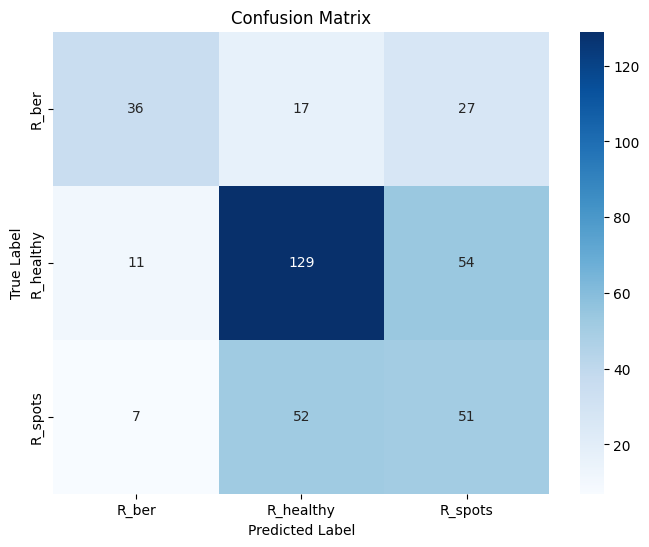

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

def evaluate_model(model_path, data_dir, img_size=(224, 224), batch_size=32):
    print(f"\n🔹 Loading model from: {model_path}")
    model = tf.keras.models.load_model(model_path, compile=False)

    datagen = ImageDataGenerator(rescale=1./255)
    val_gen = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    print(f"🔹 Evaluating {len(val_gen.filenames)} images...")
    preds = model.predict(val_gen)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_gen.classes

    # Automatically detect available labels
    class_labels = list(val_gen.class_indices.keys())
    unique_true = np.unique(y_true)
    unique_pred = np.unique(y_pred)
    num_true_classes = len(unique_true)
    num_pred_classes = preds.shape[1]

    print(f"\n🧩 Detected {num_true_classes} true classes, {num_pred_classes} predicted classes.")

    # Adjust class_labels length to match the actual prediction shape
    if len(class_labels) != num_pred_classes:
        print(f"⚠️ Adjusting label count from {len(class_labels)} → {num_pred_classes}")
        class_labels = class_labels[:num_pred_classes]

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n✅ Accuracy: {acc:.4f}")
    print(f"✅ F1-score: {f1:.4f}\n")

    print("📊 Classification Report:")
    try:
        print(classification_report(y_true, y_pred, target_names=class_labels, zero_division=0))
    except ValueError:
        print("⚠️ Warning: Adjusting label mismatch automatically.")
        print(classification_report(y_true, y_pred, labels=unique_true, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


# 🔸 Evaluate your models
evaluate_model(
    model_path="/content/drive/MyDrive/Tomato_dataset/models/green_cnn(v2).h5",
    data_dir="/content/drive/MyDrive/Tomato_dataset/cnn_crops/green/val"
)

evaluate_model(
    model_path="/content/drive/MyDrive/Tomato_dataset/models/ripe_cnn(v2).keras",
    data_dir="/content/drive/MyDrive/Tomato_dataset/cnn_crops/ripe/val"
)



In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score, accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def extended_evaluation(y_true, y_pred, y_prob, class_labels):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1-score: {f1:.4f}")
    print(f"✅ Cohen’s Kappa: {kappa:.4f}")

    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels, zero_division=0))

    # Confusion Matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d",
                xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curves for each class
    plt.figure(figsize=(8,6))
    for i, label in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_true == i, y_prob[:, i])
        plt.plot(fpr, tpr, label=f"{label} (AUC={auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


In [12]:
import os

path = "/content/drive/MyDrive/Tomato_dataset/models/"
print("Files in model folder:\n", os.listdir(path))


Files in model folder:
 ['yolov8m_trained.pt', 'model.V2', 'ripe_cnn.h5', 'ripe_cnn.keras', 'green_cnn.h5', 'green_mobilenet.keras', 'ripe_mobilenet.keras', 'ripe_cnn(v2).h5', 'ripe_cnn(v2).keras', 'green_cnn(v2).h5', 'green_cnn(v2).keras']
